In [2]:
import pandas as pd
import numpy as np

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [4]:
!wget $data 

--2025-10-20 18:36:40--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.001s  

2025-10-20 18:36:41 (63.5 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [6]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [7]:
# step 1: Import libraries
from sklearn.model_selection import train_test_split

# Step 2: Check for missing values
print("Missing values per column:")
print(df.isnull().sum(), "\n")

# Step 3: Handle missing values
# Separate categorical and numerical columns
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(exclude=['object']).columns

# Fill missing values
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

# Verify no missing values remain
print("Missing values after filling:")
print(df.isnull().sum(), "\n")

# Step 4: Split data into train/validation/test (60%/20%/20%)
# Define target variable
target = 'converted'  # this is the column to be predicted

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# First split: train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1
)

# Second split: validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)

# Display dataset shapes
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")


Missing values per column:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64 

Missing values after filling:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64 

Train shape: (877, 8)
Validation shape: (292, 8)
Test shape: (293, 8)


In [8]:

from sklearn.metrics import roc_auc_score

# Step 1: Identify numerical columns
numerical = X_train.select_dtypes(exclude=['object']).columns

# Step 2: Compute ROC AUC for each numerical feature
print("ROC AUC scores for numerical features:\n")
feature_auc = {}

for col in numerical:
    score = roc_auc_score(y_train, X_train[col])
    
    # If AUC < 0.5, invert the feature
    if score < 0.5:
        score = roc_auc_score(y_train, -X_train[col])
        direction = "inverted"
    else:
        direction = "normal"
    
    feature_auc[col] = score
    print(f"{col:<25} AUC: {score:.3f} ({direction})")

# Step 3: Sort features by importance (descending AUC)
sorted_features = sorted(feature_auc.items(), key=lambda x: x[1], reverse=True)

print("\n=== Features sorted by ROC AUC importance ===")
for feat, auc in sorted_features:
    print(f"{feat:<25} {auc:.3f}")


ROC AUC scores for numerical features:

number_of_courses_viewed  AUC: 0.765 (normal)
annual_income             AUC: 0.545 (normal)
interaction_count         AUC: 0.727 (normal)
lead_score                AUC: 0.611 (normal)

=== Features sorted by ROC AUC importance ===
number_of_courses_viewed  0.765
interaction_count         0.727
lead_score                0.611
annual_income             0.545


In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#  One-hot encoding with DictVectorizer
dv = DictVectorizer(sparse=False)

# convert dataframes to list-of-dicts
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

X_train_enc = dv.fit_transform(train_dicts)
X_val_enc = dv.transform(val_dicts)

#  Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_enc, y_train)

#  Predict probabilities on the validation set and compute AUC
y_val_pred_proba = model.predict_proba(X_val_enc)[:, 1]
auc = roc_auc_score(y_val, y_val_pred_proba)

print("Validation ROC AUC: {:.3f}".format(auc))


Validation ROC AUC: 0.794


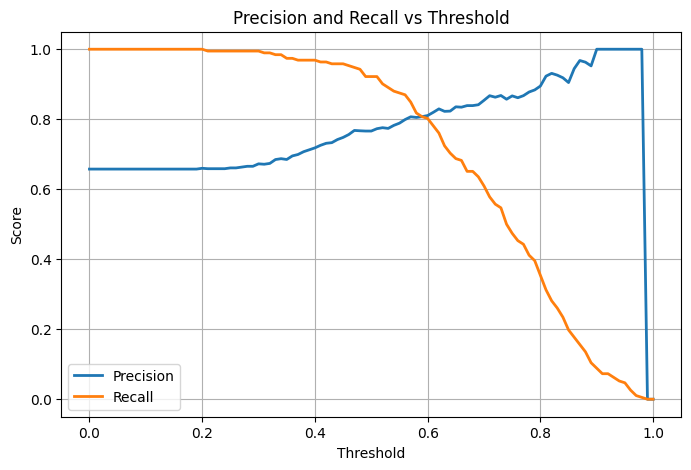

In [10]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score



# Step 1: Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

# Step 2: Compute precision and recall for each threshold
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred = (y_val_pred_proba >= t).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Step 3: Plot Precision and Recall vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


Maximum F1-score: 0.848 at threshold = 0.47


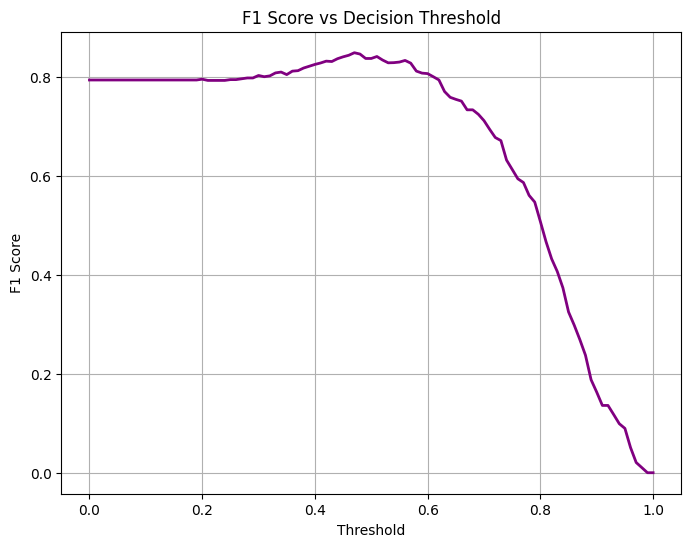

In [11]:

from sklearn.metrics import precision_score, recall_score


# Step 1: Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

# Step 2: Initialize lists
f1_scores = []

# Step 3: Compute F1 for each threshold
for t in thresholds:
    y_pred = (y_val_pred_proba >= t).astype(int)
    
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    
    # F1 formula: 2 * (P * R) / (P + R)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
        
    f1_scores.append(f1)

# Step 4: Find threshold with maximum F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Maximum F1-score: {best_f1:.3f} at threshold = {best_threshold:.2f}")

# Step 5: (Optional) Plot F1 vs Threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, color='purple', linewidth=2)
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [12]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Split into train/validation/test (60/20/20) as before
X = df.drop(columns=[target])
y = df[target]

X_train60, X_temp40, y_train60, y_temp40 = train_test_split(X, y, test_size=0.4, random_state=1)
X_val20, X_test20, y_val20, y_test20 = train_test_split(X_temp40, y_temp40, test_size=0.5, random_state=1)

# Build df_full_train as combination of train (60%) + validation (20%) -> 80% of data
df_full_train = pd.concat([X_train60, X_val20], axis=0).reset_index(drop=True)
y_full_train = pd.concat([y_train60, y_val20], axis=0).reset_index(drop=True)

# -------------------------
# K-Fold cross-validation
# -------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

fold = 0
for train_idx, val_idx in kf.split(df_full_train):
    fold += 1
    # split df_full_train into current fold's train/validation
    df_train = df_full_train.iloc[train_idx].reset_index(drop=True)
    y_train = y_full_train.iloc[train_idx].reset_index(drop=True)
    
    df_val = df_full_train.iloc[val_idx].reset_index(drop=True)
    y_val = y_full_train.iloc[val_idx].reset_index(drop=True)
    
    # DictVectorizer (one-hot encoding for categorical features)
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_train_enc = dv.fit_transform(train_dicts)
    X_val_enc = dv.transform(val_dicts)
    
    # Train Logistic Regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train)
    
    # Predict probabilities on validation fold and compute AUC
    y_val_pred_proba = model.predict_proba(X_val_enc)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_proba)
    
    auc_scores.append(auc)
    print(f"Fold {fold}: AUC = {auc:.4f}")

# -------------------------
# Results: mean and std
# -------------------------
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores, ddof=0)   # population std; use ddof=1 for sample std if preferred

print("\nAUC scores:", [round(s, 4) for s in auc_scores])
print(f"Mean AUC: {auc_mean:.4f}")
print(f"Std of AUC across folds: {auc_std:.4f}")


Fold 1: AUC = 0.8067
Fold 2: AUC = 0.8068
Fold 3: AUC = 0.8648
Fold 4: AUC = 0.8334
Fold 5: AUC = 0.8154

AUC scores: [0.8067, 0.8068, 0.8648, 0.8334, 0.8154]
Mean AUC: 0.8254
Std of AUC across folds: 0.0220


In [13]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# We reuse df_full_train and y_full_train from previous steps
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    auc_scores = []
    fold = 0
    
    for train_idx, val_idx in kf.split(df_full_train):
        fold += 1
        df_train = df_full_train.iloc[train_idx].reset_index(drop=True)
        y_train = y_full_train.iloc[train_idx].reset_index(drop=True)
        
        df_val = df_full_train.iloc[val_idx].reset_index(drop=True)
        y_val = y_full_train.iloc[val_idx].reset_index(drop=True)
        
        # One-hot encoding with DictVectorizer
        dv = DictVectorizer(sparse=False)
        train_dicts = df_train.to_dict(orient='records')
        val_dicts = df_val.to_dict(orient='records')
        
        X_train_enc = dv.fit_transform(train_dicts)
        X_val_enc = dv.transform(val_dicts)
        
        # Train Logistic Regression with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_enc, y_train)
        
        # Predict probabilities and compute AUC
        y_val_pred_proba = model.predict_proba(X_val_enc)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred_proba)
        auc_scores.append(auc)
    
    # Compute mean and std
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    print(f"C={C:<9} Mean AUC={mean_auc:.3f}  Std={std_auc:.3f}")



C=1e-06     Mean AUC=0.543  Std=0.025
C=0.001     Mean AUC=0.864  Std=0.014
C=1         Mean AUC=0.825  Std=0.022
